In [1]:
import os
import torch
import numpy as np

import scanpy as sc
from anndata import AnnData
import anndata as ad

result_dir = "../edges/"
raw_type=False
use_edge=False

In [2]:
samples=['sample1_rep1', 'sample1_rep2']
sample='sample1_rep1'#samples[7]
data_dir = "../../data/BC/processed1/"
str_position_x='centerx'
str_position_y='centery'
str_cell_type='subclass'
cell_types=['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2', 'Endothelial', 'IRF7+_DCs', 'Invasive_Tumor', 'LAMP3+_DCs', 'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+', 'Myoepi_KRT15+', 'Perivascular-Like', 'Prolif_Invasive_Tumor', 'Stromal', 'Stromal_&_T_Cell_Hybrid', 'T_Cell_&_Tumor_Hybrid', 'Unlabeled']
print(cell_types)

genes = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")
print("GFAP" in genes,genes)
type_exp_dict=np.load(data_dir + sample + "_TypeExp.npz", allow_pickle=True)

cell_type_pair_sequence=[]
for cell_typei in cell_types:
    for cell_typej in cell_types:
        cell_type_pair_sequence.append(cell_typei+"->"+cell_typej)

feature_names=[]
for i in range(len(cell_types)):
    for j in range(len(genes)):
        feature_names.append(cell_types[i]+"--"+genes[j])

In [3]:
genes = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")
type_exp_dict=np.load(data_dir + sample + "_TypeExp.npz", allow_pickle=True)

In [4]:
import pandas as pd
def load_sample_position(sample,add_column=True,no_other=True):
    df = pd.read_csv(data_dir+sample+".csv")
    # Step 1: Create a new column based on conditions
    df['cell_type_plot'] = df[str_cell_type].apply(
        lambda x: x[:2] if x.startswith('L') and x[1].isdigit() else "Other_not_excitatory_neuron"
    )
    print(np.unique(df['cell_type_plot'].values))
    adata_position=AnnData(np.zeros((df.shape[0],len(genes))))
    adata_position.obs['cell_type'] = df[str_cell_type].values
    adata_position.obs["cell_type_plot"]=df['cell_type_plot'].values
    adata_position.obs["group"]=df['cell_type_plot'].values
    adata_position.obs['to_position_x']=df[str_position_x].values
    adata_position.obs['to_position_y']=df[str_position_y].values
    adata_position.obs['from_position_x']=df[str_position_x].values
    adata_position.obs['from_position_y']=df[str_position_y].values

    if no_other:
        adata_position=adata_position[adata_position.obs["cell_type_plot"]!="Other_not_excitatory_neuron",:]
    
    return df,adata_position

df_position,adata_position=load_sample_position(sample)

['L2' 'L4' 'L5' 'L6' 'Other_not_excitatory_neuron']


In [5]:
def aggregate_interation_strength(results,target_from_cell_type='Microglia-PVM'):
    attention_scores=results["attention_score"]
    cell_type_names = np.array(results["cell_type_name"])
    # Initialize a tensor to hold aggregated interaction strengths
    B, _, C = attention_scores.shape
    t = len(cell_types)
    aggregated_interactions = torch.zeros((B, t, C))
    
    # Map cell type names to indices
    cell_type_to_index = {ct: idx for idx, ct in enumerate(cell_types)}
    
    # Aggregate interaction strengths by cell type
    for b in range(B):
        for n in range(1, 50):  # Skip the first element, which is the target cell type
            neighbor_type = cell_type_names[b][n]
            if neighbor_type in cell_type_to_index:
                idx = cell_type_to_index[neighbor_type]
                aggregated_interactions[b, idx] += attention_scores[b, n-1]
    
    #aggregated_interactions=torch.abs(aggregated_interactions)
    aggregated_interactions=aggregated_interactions/torch.sum(torch.abs(aggregated_interactions),dim=1,keepdim=True)
    aggregated_interactions[aggregated_interactions<0.05]=0
    aggregated_interactions=aggregated_interactions[:,cell_types.index('Microglia-PVM'),:]
    print(aggregated_interactions.shape)
    return aggregated_interactions

def read_data(sample,select=10,loss_threshold=None,normalize=False,target_from_cell_type='Microglia-PVM'):
    results=torch.load(result_dir+"edges_"+sample+".pth",map_location=torch.device('cpu'))
    edges=results["attention_score"]
    # modify here
    if normalize:
        attention_score=results["attention_score"]/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True)
    else:
        attention_score=results["attention_score"]
        normalized_attention_score=results["attention_score"]/torch.sum(results["attention_score"],dim=-2,keepdim=True)
    print(attention_score.shape)
    position_x=results["position_x"]
    position_y=results["position_y"]
    cell_type_name=results["cell_type_name"]
    loss1=results["loss_all"].cpu()
    
    B,N=position_x.shape
    loss1=loss1.unsqueeze(dim=-1).repeat(1,select).reshape(-1).numpy()
    
    cell_type_target=[cell_type_name[i][0] for i in range(len(cell_type_name))]
    
    if normalize:
        indices=torch.topk(torch.sum(attention_score,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(attention_score,dim=-1),k=select,dim=-1))
    else:
        tmp=torch.abs(torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True))
        indices=torch.topk(torch.sum(tmp,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(tmp,dim=-1),k=select,dim=-1))
    indices_tmp=torch.arange(0,indices.shape[0],1).unsqueeze(dim=-1).repeat(1,select)
    indices=torch.stack([indices_tmp.reshape(-1),indices.reshape(-1)],dim=0)

    if not use_edge:
        edges=attention_score
        print("not use edge",edges.shape)
    
    edges=edges[indices[0],indices[1],:].reshape(-1,edges.shape[-1]).numpy()
    attention_score=attention_score[indices[0],indices[1],:].reshape(-1,attention_score.shape[-1]).numpy()
    
    to_position_x=position_x[:,0:1].repeat(1,select).reshape(-1).numpy()
    to_position_y=position_y[:,0:1].repeat(1,select).reshape(-1).numpy()
    from_position_x=position_x[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    from_position_y=position_y[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    
    dx=position_x-position_x[:,0:1]
    dy=position_y-position_y[:,0:1]
    distances=torch.sqrt(torch.square(dx)+torch.square(dy))
    distances=distances[indices[0],indices[1]].reshape(-1).numpy()
    
    indices_np=indices.numpy()
    cell_types=np.array(cell_type_name)[:,1:][indices_np[0],indices_np[1]].reshape(B,select)
    print("number of cell types in this sample:",np.unique(np.array(cell_type_name)[:,0],return_counts=True))
    cell_types_pair=[]
    cell_types_target=[]
    cell_types_from=[]
    flags=[]
    for i in range(cell_types.shape[0]):
        for j in range(cell_types.shape[1]):
            if not raw_type:
                cell_types_pair.append(cell_types[i][j]+"->"+cell_type_target[i])
                flags.append(cell_type_target[i]!=cell_types[i][j])
                cell_types_target.append(cell_type_target[i])
                cell_types_from.append(cell_types[i][j])
            else:
                cell_types_pair.append(cell_types[i][j].split(" ")[0]+"->"+cell_type_target[i].split(" ")[0])
                flags.append(cell_types[i][j].split(" ")[0]!=cell_type_target[i].split(" ")[0])
                cell_types_target.append(cell_type_target[i].split(" ")[0])
                cell_types_from.append(cell_types[i][j].split(" ")[0])

    print(edges.shape)
    adata = AnnData(edges)
    adata.obs['cell_type'] = cell_types_pair
    adata.obs["cell_types_from"]=cell_types_from
    adata.obs['cell_type_target']=cell_types_target
    adata.obs['from_position_x'] = from_position_x
    adata.obs['from_position_y'] = from_position_y
    adata.obs['to_position_x'] = to_position_x
    adata.obs['to_position_y'] = to_position_y
    adata.obs['distance']=distances
    adata.obs['loss']=loss1
    
    # modify here
    type_exps=torch.stack([torch.Tensor(type_exp_dict[cell_type_targeti]) for cell_type_targeti in cell_type_target],dim=0)
    results["y"]=results["y"]+type_exps
    
    adata.obsm["y"]=results["y"].repeat(1,select).reshape(results["y"].shape[0]*select,results["y"].shape[1]).numpy()
    adata.obsm["attention_score"]=attention_score

    from_strength=aggregate_interation_strength(results=results,target_from_cell_type=target_from_cell_type)
    adata.obsm["strength"]=from_strength.repeat(1,select).reshape(from_strength.shape[0]*select,from_strength.shape[1]).numpy()

    if loss_threshold is None:
        loss_threshold=np.mean(loss1)+np.std(loss1)*2
    adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]
    
    return adata
    
adata=read_data(sample,select=5,normalize=False)
print(adata)

torch.Size([4709, 49, 140])
torch.return_types.topk(
values=tensor([[0.0888, 0.0609, 0.0443, 0.0390, 0.0329],
        [0.2256, 0.0480, 0.0372, 0.0348, 0.0295],
        [0.1580, 0.1224, 0.0500, 0.0420, 0.0382],
        ...,
        [0.1061, 0.0840, 0.0830, 0.0708, 0.0630],
        [0.0827, 0.0547, 0.0544, 0.0487, 0.0380],
        [0.1118, 0.0566, 0.0563, 0.0434, 0.0428]]),
indices=tensor([[ 0, 23,  1, 26, 15],
        [ 0, 10,  3,  9, 12],
        [ 0, 16, 37, 11, 39],
        ...,
        [37, 46, 29, 28, 13],
        [ 0,  8, 48, 24, 22],
        [ 1,  4, 30, 13,  5]]))
not use edge torch.Size([4709, 49, 140])
number of cell types in this sample: (array(['Astrocyte', 'Chandelier', 'Endothelial', 'L2/3 IT', 'L4 IT',
       'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b',
       'Lamp5', 'Lamp5 Lhx6', 'Microglia-PVM', 'OPC', 'Oligodendrocyte',
       'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
      dtype='<U15'), array([ 438,   19,  203,  436,  366, 

/tmp/ipykernel_2159233/1405394137.py:118: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]


selecting edge types: ['L2/3 IT->Microglia-PVM' 'Oligodendrocyte->Microglia-PVM'
 'Astrocyte->Microglia-PVM' 'L5 IT->Microglia-PVM'
 'Microglia-PVM->Oligodendrocyte' 'L4 IT->Microglia-PVM' 'L5 IT->L4 IT'
 'Microglia-PVM->L2/3 IT' 'L2/3 IT->Astrocyte' 'L2/3 IT->L4 IT']


/tmp/ipykernel_2159233/2335886016.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

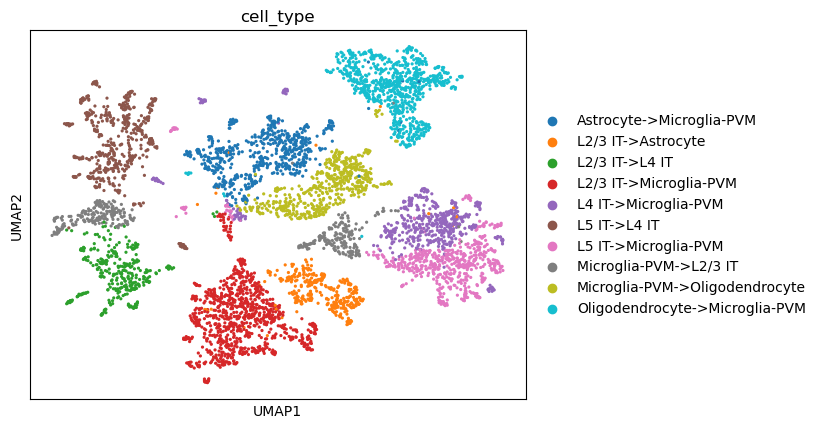

selecting edge types: ['L2/3 IT->Microglia-PVM' 'Oligodendrocyte->Microglia-PVM'
 'Astrocyte->Microglia-PVM' 'L5 IT->Microglia-PVM'
 'Microglia-PVM->Oligodendrocyte' 'L4 IT->Microglia-PVM' 'L5 IT->L4 IT'
 'Microglia-PVM->L2/3 IT' 'L2/3 IT->Astrocyte' 'L2/3 IT->L4 IT']


/tmp/ipykernel_2159233/2335886016.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

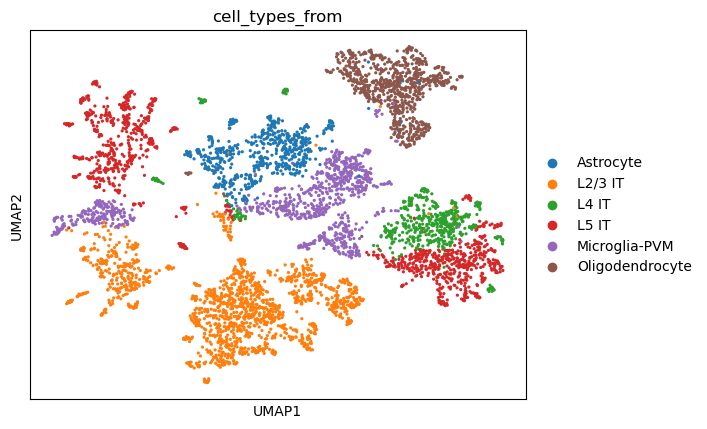

/tmp/ipykernel_2159233/2335886016.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]


selecting edge types: ['L2/3 IT->Microglia-PVM' 'Oligodendrocyte->Microglia-PVM'
 'Astrocyte->Microglia-PVM' 'L5 IT->Microglia-PVM'
 'Microglia-PVM->Oligodendrocyte' 'L4 IT->Microglia-PVM' 'L5 IT->L4 IT'
 'Microglia-PVM->L2/3 IT' 'L2/3 IT->Astrocyte' 'L2/3 IT->L4 IT']


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


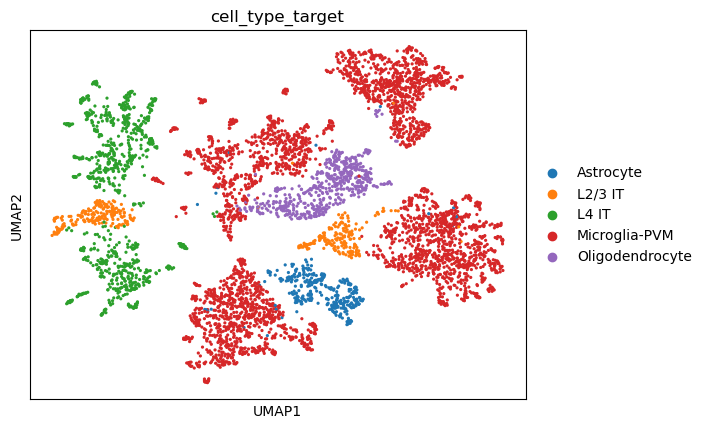

/tmp/ipykernel_2159233/2335886016.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]


selecting edge types: ['L2/3 IT->Microglia-PVM' 'Oligodendrocyte->Microglia-PVM'
 'Astrocyte->Microglia-PVM' 'L5 IT->Microglia-PVM'
 'Microglia-PVM->Oligodendrocyte' 'L4 IT->Microglia-PVM' 'L5 IT->L4 IT'
 'Microglia-PVM->L2/3 IT' 'L2/3 IT->Astrocyte' 'L2/3 IT->L4 IT']


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


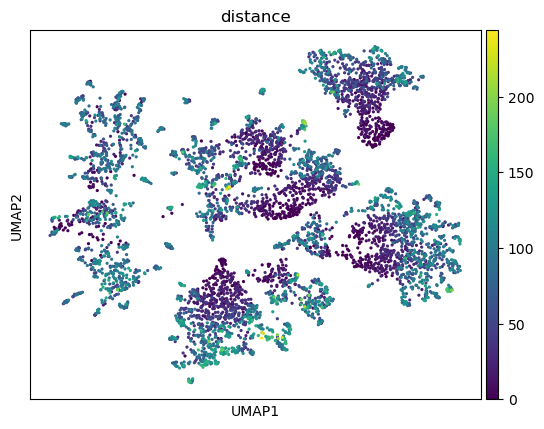

View of AnnData object with n_obs × n_vars = 21183 × 140
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss'
    obsm: 'y', 'attention_score', 'strength'

In [6]:
def plot(adata,color='cell_type',select_type_number=None,select_type=None):
    assert not ((select_type is None and select_type_number is None) and (select_type is not None and select_type_number is not None))
    
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
    print("selecting edge types:", select_type)
    
    flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
    adata_filtered=adata[flag,:]

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered, n_comps=50)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    # Plot UMAP
    sc.pl.umap(adata_filtered, color=color)
    return adata

plot(adata,select_type_number=10)
plot(adata,select_type_number=10,color="cell_types_from")
plot(adata,select_type_number=10,color='cell_type_target')
plot(adata,select_type_number=10,color="distance")

In [7]:
unique=np.unique(adata.obs['cell_type'],return_counts=True)
unique_arg=np.argsort(-unique[1])
print(unique[0][unique_arg].tolist(),unique[1][unique_arg].tolist())

['L2/3 IT->Microglia-PVM', 'Oligodendrocyte->Microglia-PVM', 'Astrocyte->Microglia-PVM', 'L5 IT->Microglia-PVM', 'Microglia-PVM->Oligodendrocyte', 'L4 IT->Microglia-PVM', 'L5 IT->L4 IT', 'Microglia-PVM->L2/3 IT', 'L2/3 IT->Astrocyte', 'L2/3 IT->L4 IT', 'L6 IT->Microglia-PVM', 'VLMC->Microglia-PVM', 'Microglia-PVM->Astrocyte', 'L4 IT->L5 IT', 'OPC->Oligodendrocyte', 'L6 IT->Oligodendrocyte', 'Astrocyte->Oligodendrocyte', 'L2/3 IT->Oligodendrocyte', 'Astrocyte->L2/3 IT', 'L6 IT Car3->Microglia-PVM', 'L6 IT->Astrocyte', 'L5 IT->Oligodendrocyte', 'L6b->Oligodendrocyte', 'OPC->Microglia-PVM', 'Endothelial->Astrocyte', 'Endothelial->VLMC', 'VLMC->Endothelial', 'L4 IT->L2/3 IT', 'L6 IT Car3->Oligodendrocyte', 'L5 IT->Astrocyte', 'Endothelial->Microglia-PVM', 'VLMC->Astrocyte', 'L4 IT->Oligodendrocyte', 'Microglia-PVM->Endothelial', 'Microglia-PVM->L4 IT', 'Oligodendrocyte->OPC', 'VLMC->Oligodendrocyte', 'Microglia-PVM->VLMC', 'Sst->L4 IT', 'Oligodendrocyte->L5 IT', 'Oligodendrocyte->L2/3 IT',

In [8]:
desired_CCC_type='Microglia-PVM->L2/3 IT'#'L2/3 IT__Microglia-PVM'#'Endo__Oligo'#'Endo__Astro'#'Micro__Endo'#'Astro__Oligo'#'OPC__L2/3 IT'#'Micro__L4/5 IT'#'OPC__L4/5 IT'#'Micro__L4/5 IT','Micro__L6 CT'

def get_type_adata(adata,cell_type_pair):
    to_type=cell_type_pair.split("->")[1]
    flag1=[i==to_type for i in adata.obs['cell_type_target']]
    adata_type=adata[flag1]
    
    flag2=[i==cell_type_pair for i in adata_type.obs['cell_type']]
    adata_type.obs["is_target_interaction"]=flag2
    adata_type.obs["is_target_interaction_str"]=[str(i) for i in flag2]
    print(np.sum(flag2),adata_type.shape[0])
    return adata_type

adata_type=get_type_adata(adata,desired_CCC_type)

389 1886


/tmp/ipykernel_2159233/921615172.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_type.obs["is_target_interaction"]=flag2


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


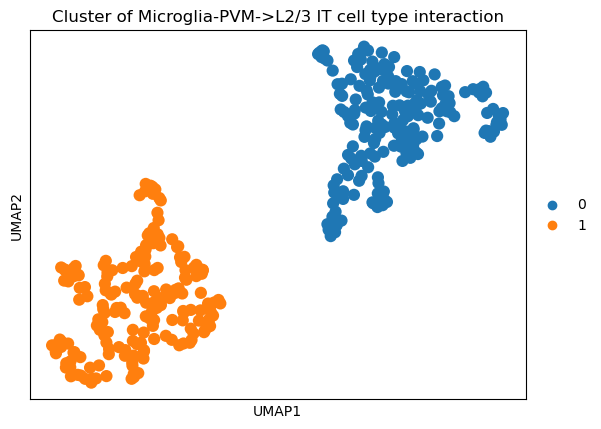

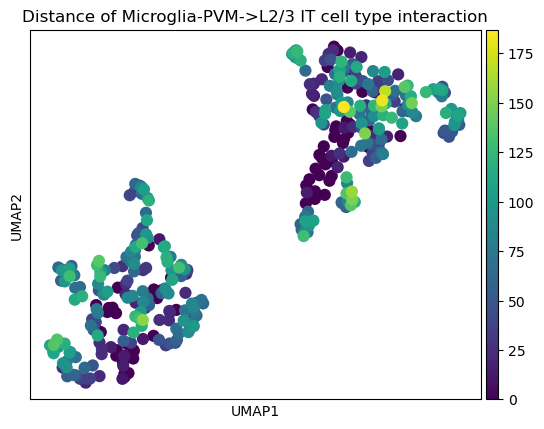

In [9]:
def cluster_and_plot(adata_original,desired_CCC_type):
    adata=adata_original.copy()
    sc.pp.scale(adata)
    # PCA
    sc.tl.pca(adata,n_comps=40)
    # Neighborhood Graph
    sc.pp.neighbors(adata, n_neighbors=10)
    # Clustering
    sc.tl.leiden(adata,resolution=0.04)  # or sc.tl.louvain(adata)
    # Visualization
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='leiden',title="Cluster of "+desired_CCC_type+" cell type interaction")
    sc.pl.umap(adata, color='distance',title="Distance of "+desired_CCC_type+" cell type interaction")
    return np.array(adata.obs['leiden'].values),adata
leiden,adata_tmp=cluster_and_plot(adata_type[adata_type.obs["is_target_interaction"]],desired_CCC_type)

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


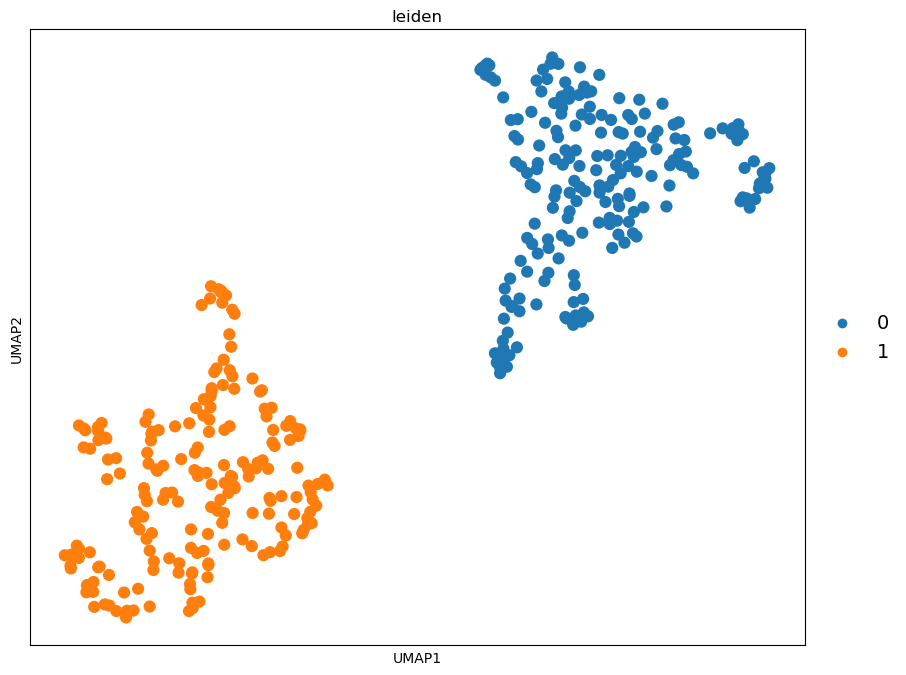

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(adata_tmp, color='leiden',ax=ax,legend_fontsize=14)

In [11]:
def merge_group(adata_type,groups):
    groups1=[]
    cnt=0
    for i in range(len(adata_type.obs["is_target_interaction"])):
        if adata_type.obs["is_target_interaction"][i]==False:
            groups1.append("-1")
        else:
            groups1.append(groups[cnt])
            cnt=cnt+1
    assert cnt==len(groups)
    adata_type.obs["group"]=groups1
    return adata_type

adata_type=merge_group(adata_type,leiden)
print(adata_type)

AnnData object with n_obs × n_vars = 1886 × 140
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
    obsm: 'y', 'attention_score', 'strength'


/tmp/ipykernel_2159233/1162171487.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata_type.obs["is_target_interaction"][i]==False:


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


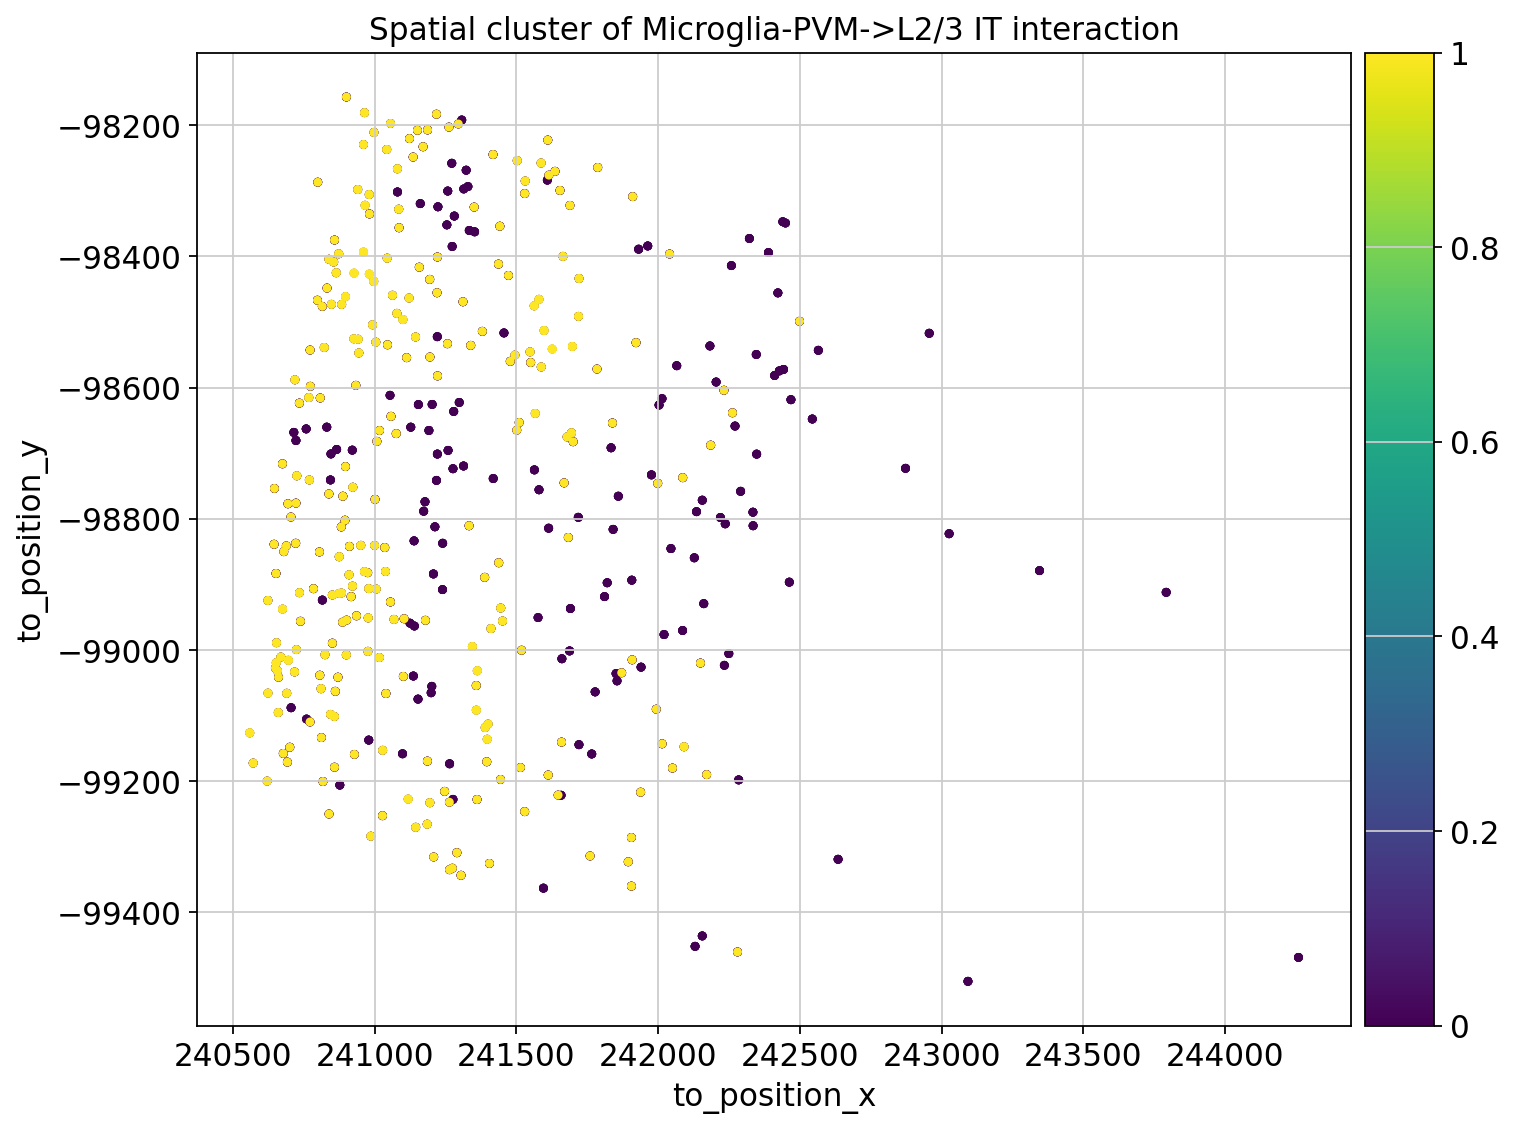

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


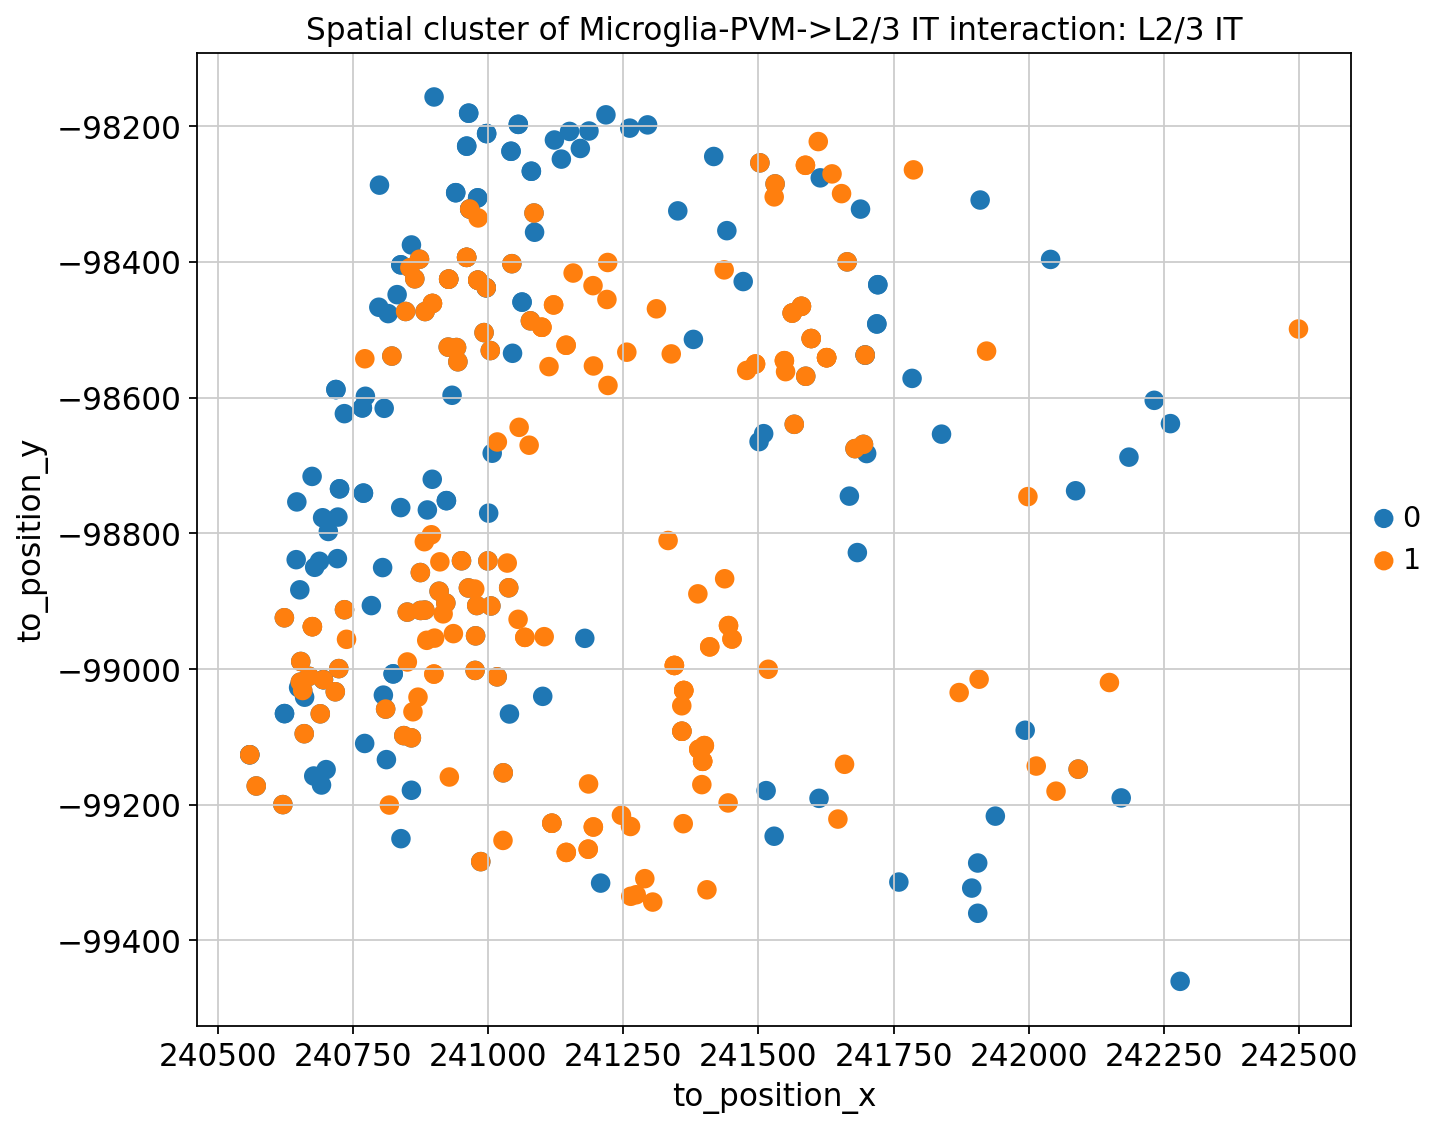

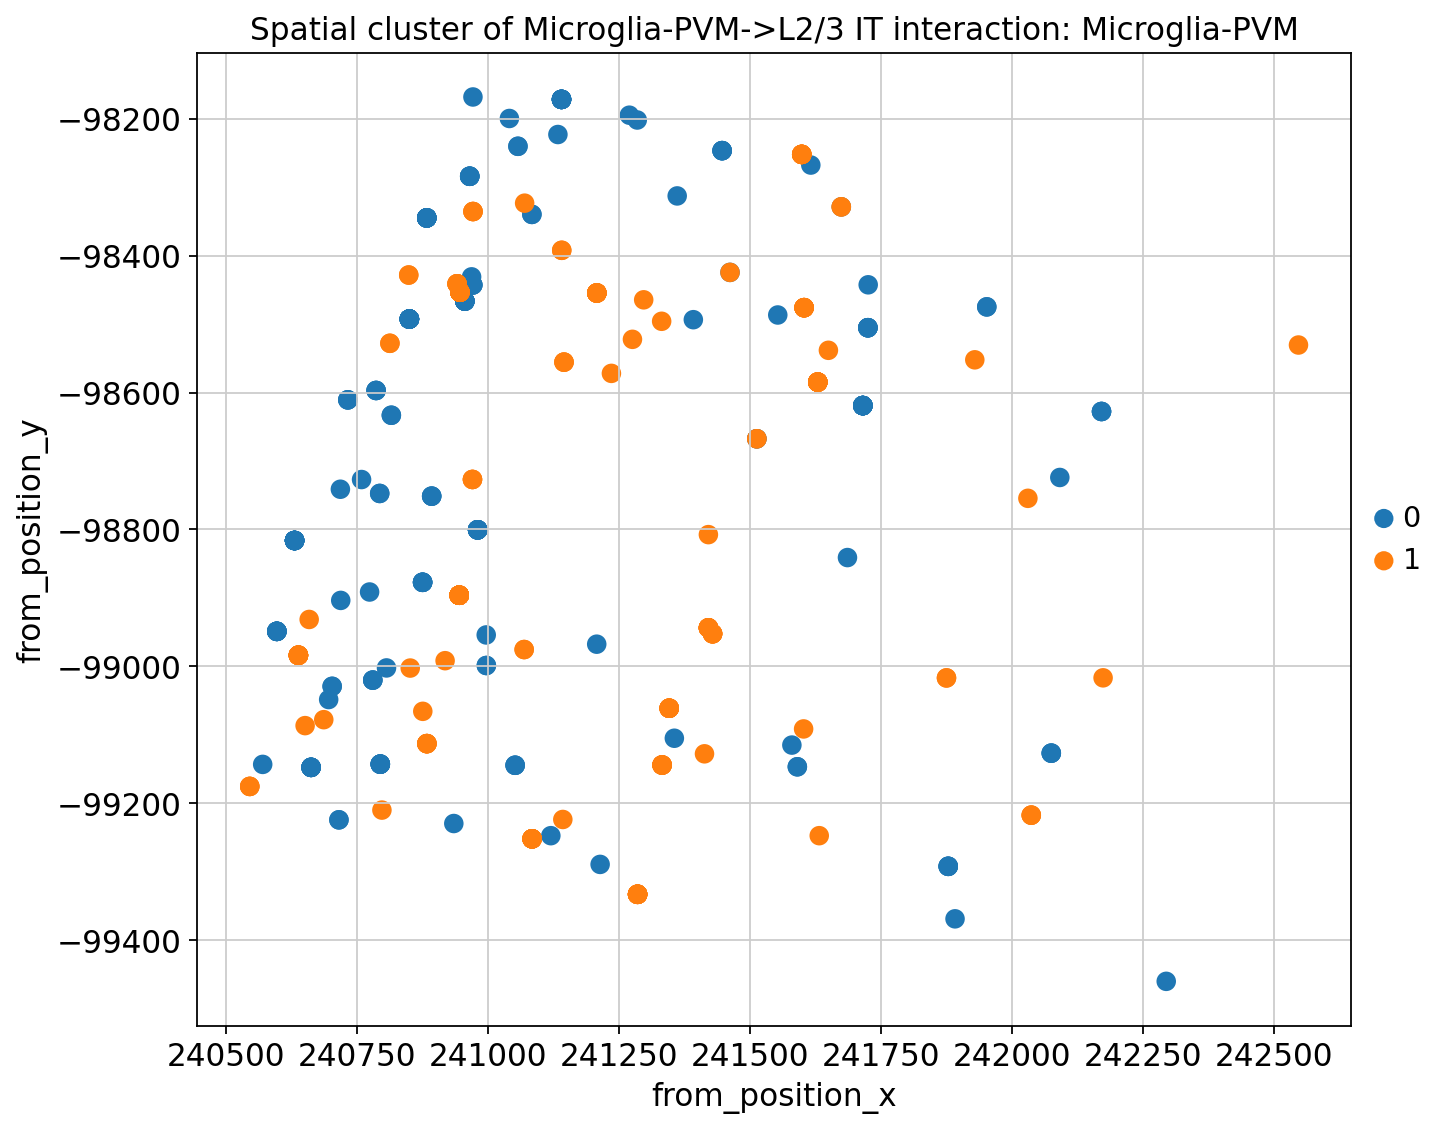

In [12]:
def spatial_visualize_type(adata,interaction_name):
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color="is_target_interaction",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
    
    from_type=interaction_name.split("->")[0]
    to_type=interaction_name.split("->")[1]
    
    adata1=adata[adata.obs["is_target_interaction"]]
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata1,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color='group',
        title=f"Spatial cluster of {interaction_name} interaction: "+to_type
    )
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata1,
        x='from_position_x',#'position_x',
        y='from_position_y',#'position_y',
        color='group',
        title=f"Spatial cluster of {interaction_name} interaction: "+from_type
    )
spatial_visualize_type(adata_type,desired_CCC_type)

In [13]:
def filter_same_target_cell(adata_type):
    unique_y=[]
    group_y=[]
    counts=[]
    
    useful_index=[]
    
    for i in range(adata_type.shape[0]):
        if len(unique_y)==0:
            unique_y.append(adata_type.obsm["y"][i,:])
            group_y.append(adata_type.obs["group"][i])
            useful_index.append(i)
            counts.append(1)
            continue
        if np.sum(np.abs(adata_type.obsm["y"][i,:]-unique_y[-1]))<1e-10:
            groupi=adata_type.obs["group"][i]
            counts[-1]+=1
            if int(groupi)>int(group_y[-1]):
                group_y[-1]=groupi
                useful_index[-1]=i
            continue
        unique_y.append(adata_type.obsm["y"][i,:])
        group_y.append(adata_type.obs["group"][i])
        useful_index.append(i)
        counts.append(1)
    
    adata_new=adata_type[np.array(useful_index)]
    adata_new.obs["group"]=group_y
    adata_new.obs["counts"]=counts
    return adata_new        

adata_type1=filter_same_target_cell(adata_type)
print(adata_type,adata_type1)

AnnData object with n_obs × n_vars = 1886 × 140
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
    obsm: 'y', 'attention_score', 'strength' AnnData object with n_obs × n_vars = 387 × 140
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group', 'counts'
    obsm: 'y', 'attention_score', 'strength'


/tmp/ipykernel_2159233/2081475269.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_y.append(adata_type.obs["group"][i])
/tmp/ipykernel_2159233/2081475269.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  groupi=adata_type.obs["group"][i]
/tmp/ipykernel_2159233/2081475269.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_y.append(adata_type.obs["group"][i])
/tmp/ipykernel_2159233/2081475269.py:28: ImplicitModifi

/tmp/ipykernel_2159233/2916197102.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata0.obs["group"]=[x+"_cluster" for x in adata0.obs["group"]]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


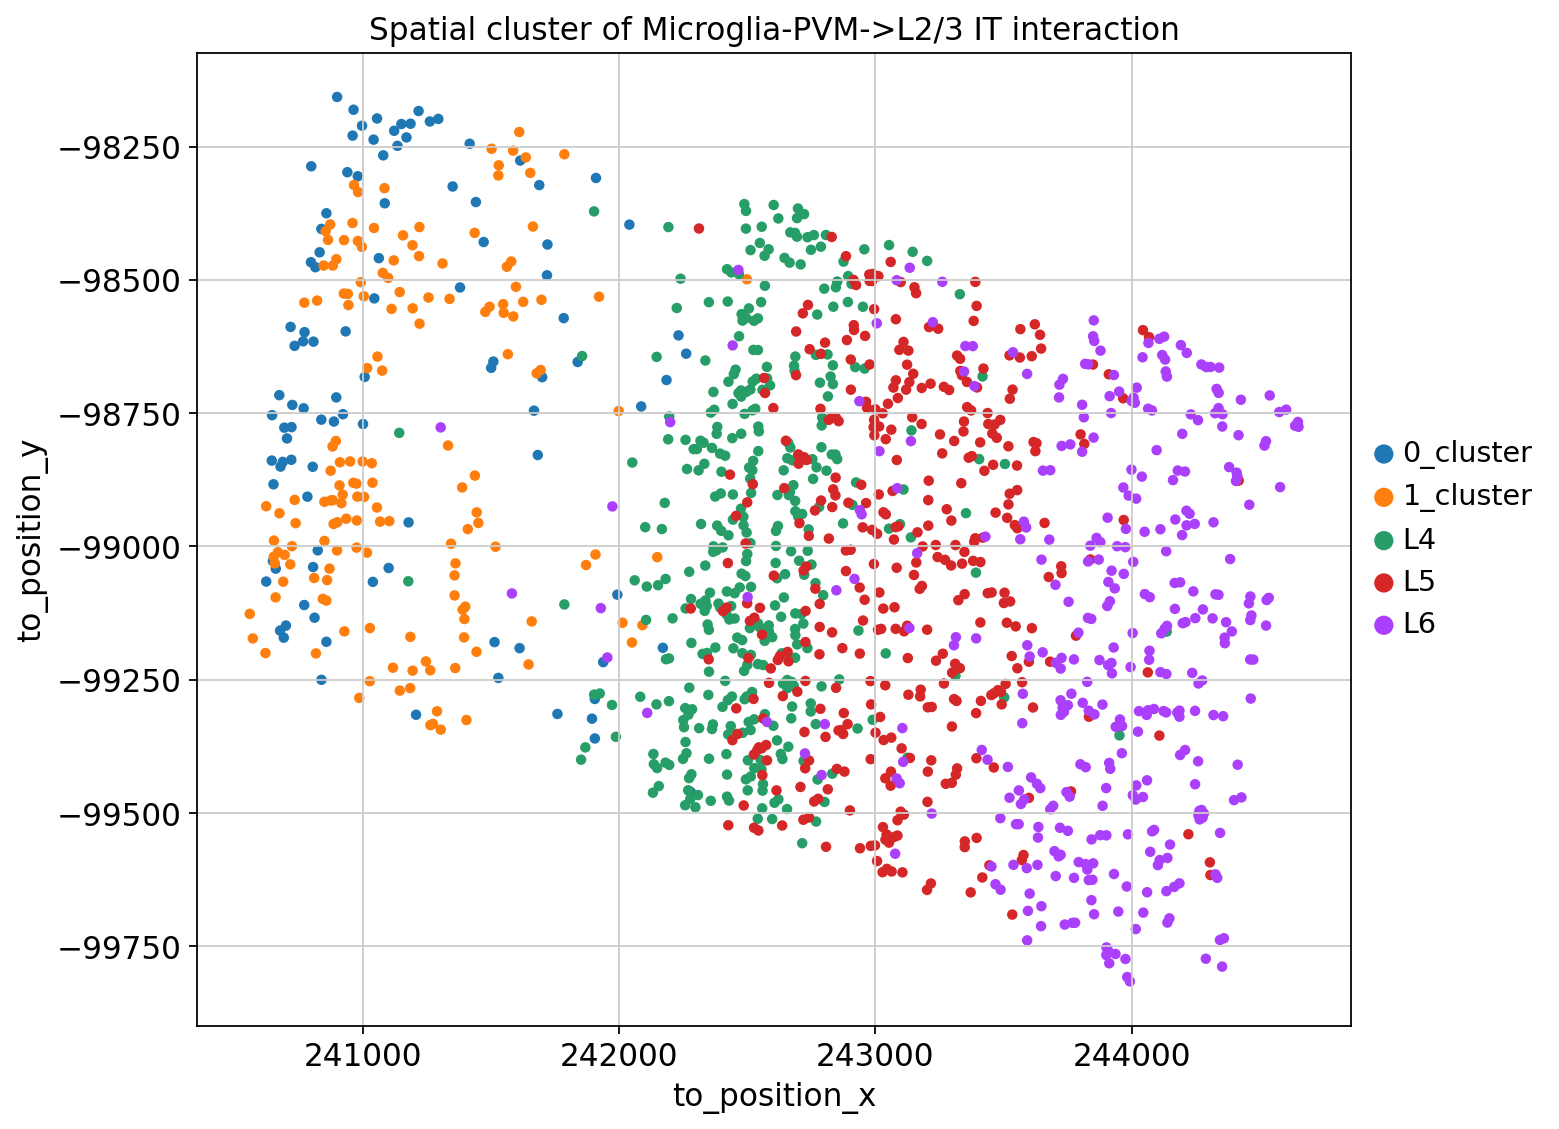

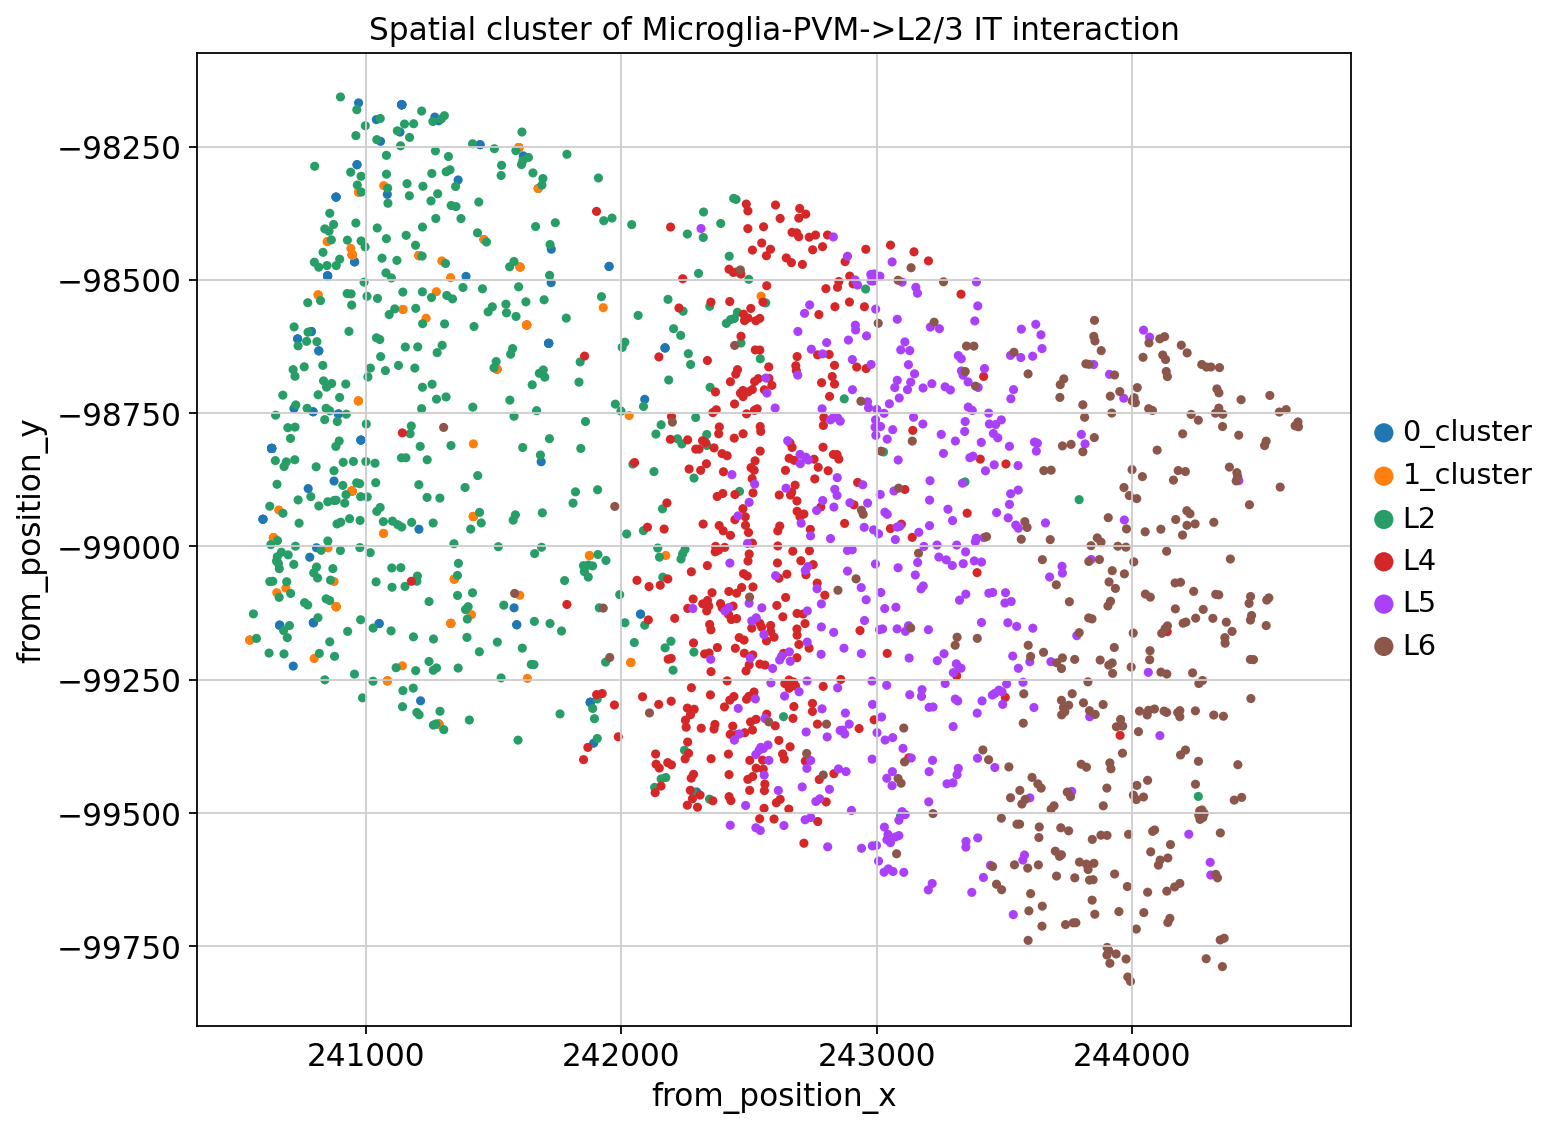

/tmp/ipykernel_2159233/2916197102.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata0.obs["group"]=[x+"_cluster" for x in adata0.obs["group"]]


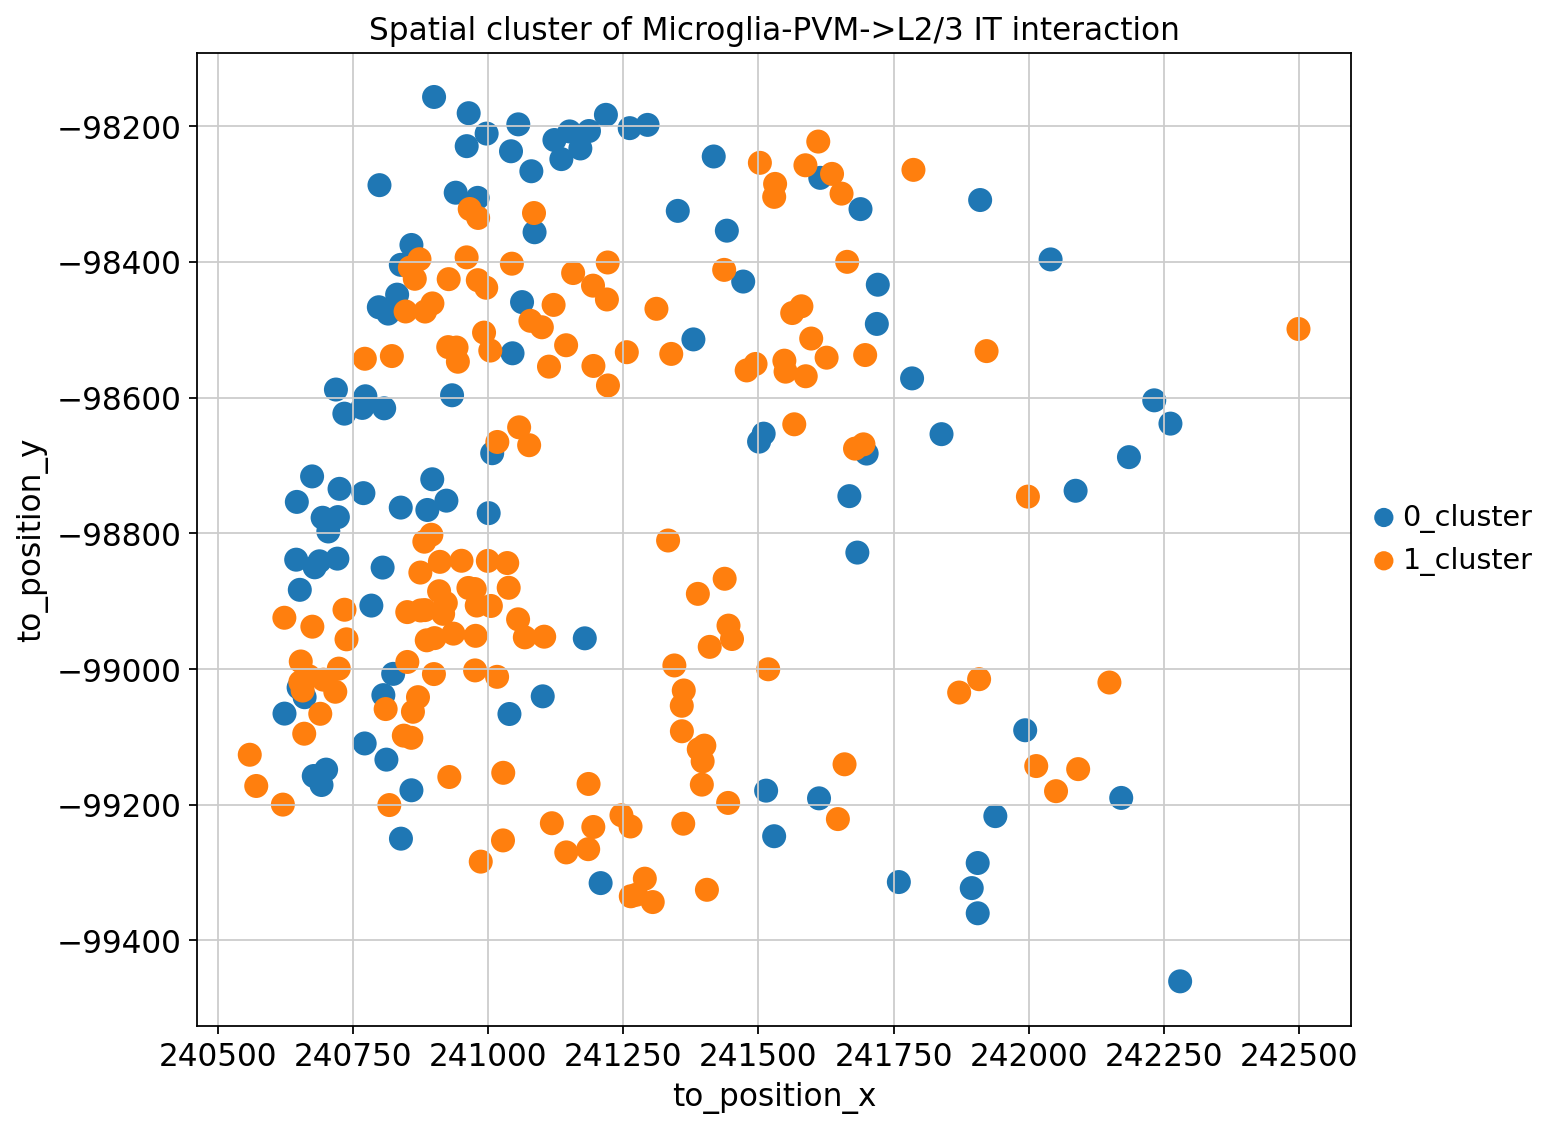

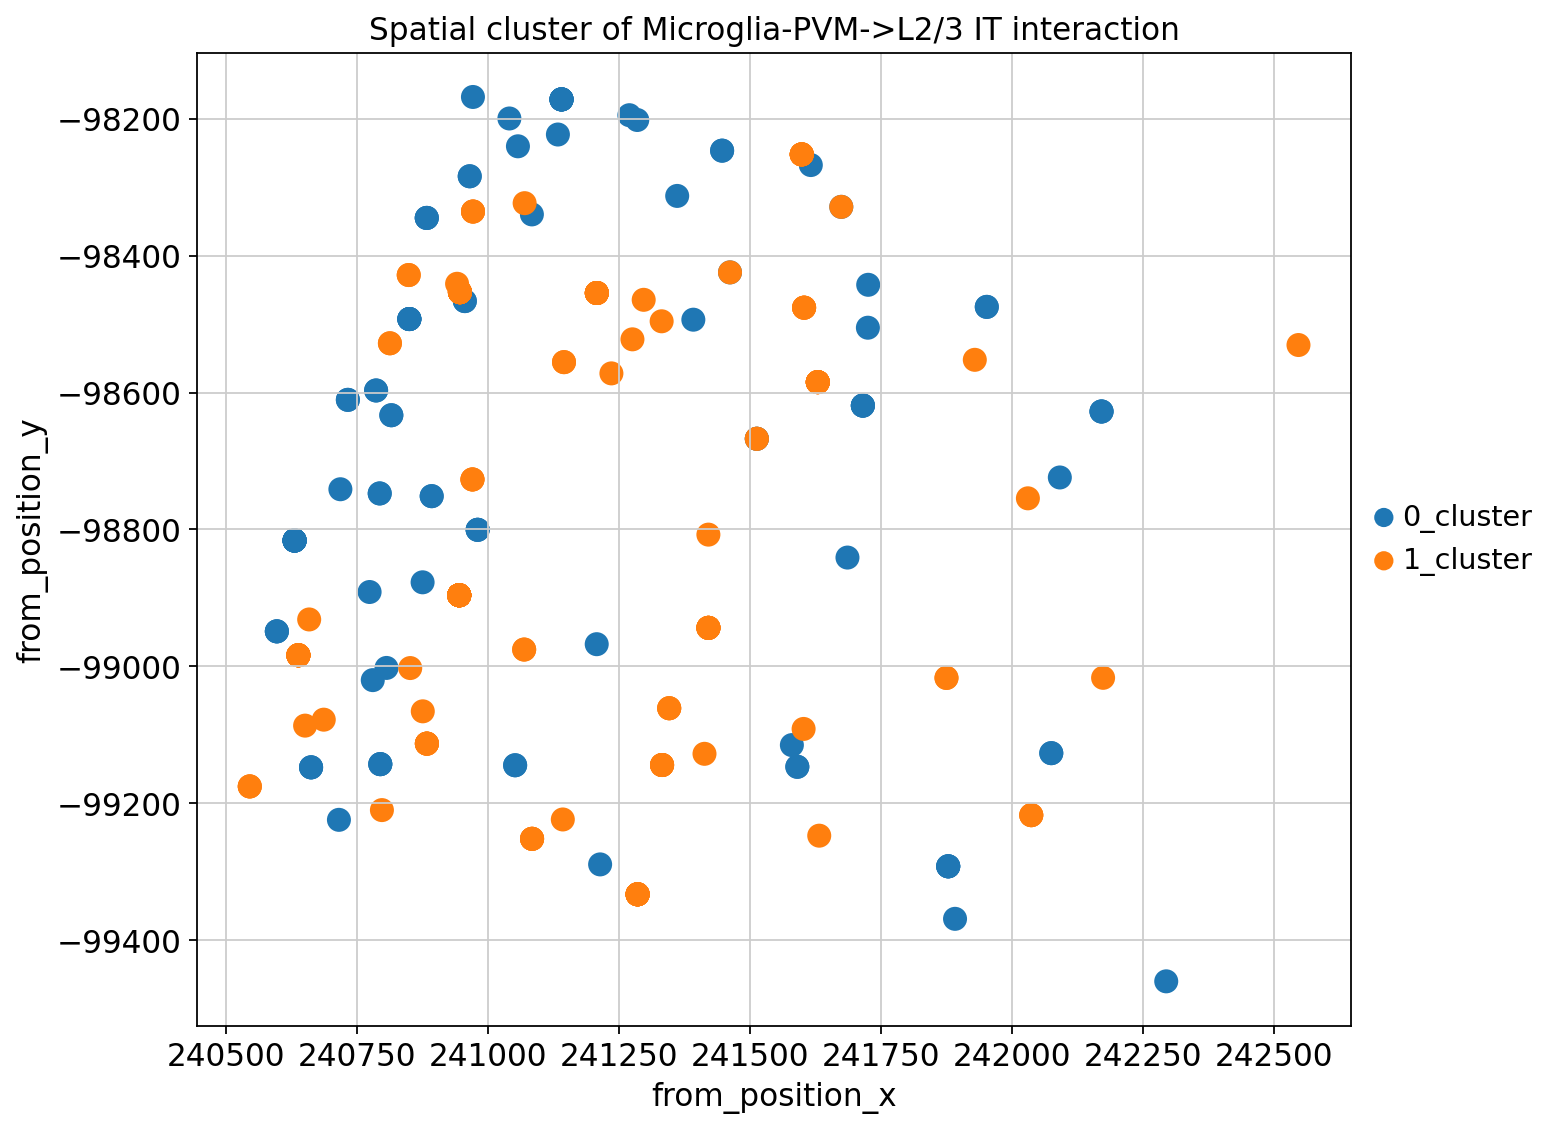

In [14]:
def spatial_visualize_type1(adata,interaction_name,plot_all=True):
    adata0=adata[adata.obs["group"]!="-1"]
    adata0.obs["group"]=[x+"_cluster" for x in adata0.obs["group"]]
    adata1=ad.concat([adata_position[adata_position.obs['cell_type']!=desired_CCC_type.split("->")[1],:],adata0],axis=0) if plot_all else adata0
    adata2=ad.concat([adata_position[adata_position.obs['cell_type']!=desired_CCC_type.split("->")[0],:],adata0],axis=0) if plot_all else adata0
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata1,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color="group",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
    sc.pl.scatter(
        adata2,
        x='from_position_x',#'position_x',
        y='from_position_y',#'position_y',
        color="group",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
spatial_visualize_type1(adata_type1,desired_CCC_type)
spatial_visualize_type1(adata_type1,desired_CCC_type,False)

In [15]:
def add_from_y(adata_type, adata):
    # Check if "y_from" exists in adata_type.obsm, if not, initialize it
    y_from=np.zeros((adata_type.n_obs, adata.obsm["y"].shape[1]))

    # Create a dictionary to map positions to "y" values in adata
    position_to_y = {
        (adata.obs.iloc[idx]["to_position_x"], adata.obs.iloc[idx]["to_position_y"]): adata.obsm["y"][idx]
        for idx in range(adata.n_obs)
    }

    # Iterate over each row in adata_type
    cnt=0
    for index, row in adata_type.obs.iterrows():
        position = (row["from_position_x"], row["from_position_y"])
        # Check if the position exists in the mapping dictionary
        if position in position_to_y:
            # Update the "y_from" value based on the found mapping
            y_from[cnt] = position_to_y[position]
            cnt=cnt+1
        else:
            print("Not found???")
    print(cnt,y_from.shape)
    adata_type.obsm["from_y"]=y_from
    
    return adata_type

adata_type1=add_from_y(adata_type1,adata)

Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
Not found???
363 (387, 140)


In [16]:
def filter_extreme_percentiles(adata, select, percentile_low=2, percentile_high=98):
    # Extracting and flattening the list of gene tuples
    gene_tuples = adata.uns['rank_genes_groups']['names'][:select]
    gene_names = [gene for tup in gene_tuples for gene in tup]  # Flatten the list of tuples into a list of gene names
    print(adata.uns['rank_genes_groups']['names'][:select],gene_names)
    # Remove duplicates if necessary
    gene_names = list(set(gene_names))

    # Data structure to keep track of which indices to keep
    indices_to_keep = set(range(adata.shape[0]))

    # Iterate over each gene, filter rows based on the percentiles
    for gene in gene_names:
        if gene in adata.var_names:
            # Calculate the low and high percentile values
            values = adata.obs_vector(gene)  # Get a numpy array of the values for this gene
            low_threshold = np.percentile(values, percentile_low)
            high_threshold = np.percentile(values, percentile_high)

            # Determine indices that fall outside the low and high thresholds
            filtered_indices = np.where((values >= low_threshold) & (values <= high_threshold))[0]
            indices_to_keep.intersection_update(filtered_indices)
        else:
            print(f"Gene {gene} not found in the variable names.")

    # Filter the adata to keep only the desired rows
    adata = adata[list(indices_to_keep), :]

    return adata

In [17]:
print(adata_type1.obsm["y"].shape,adata_type1.shape)

(387, 140) (387, 140)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


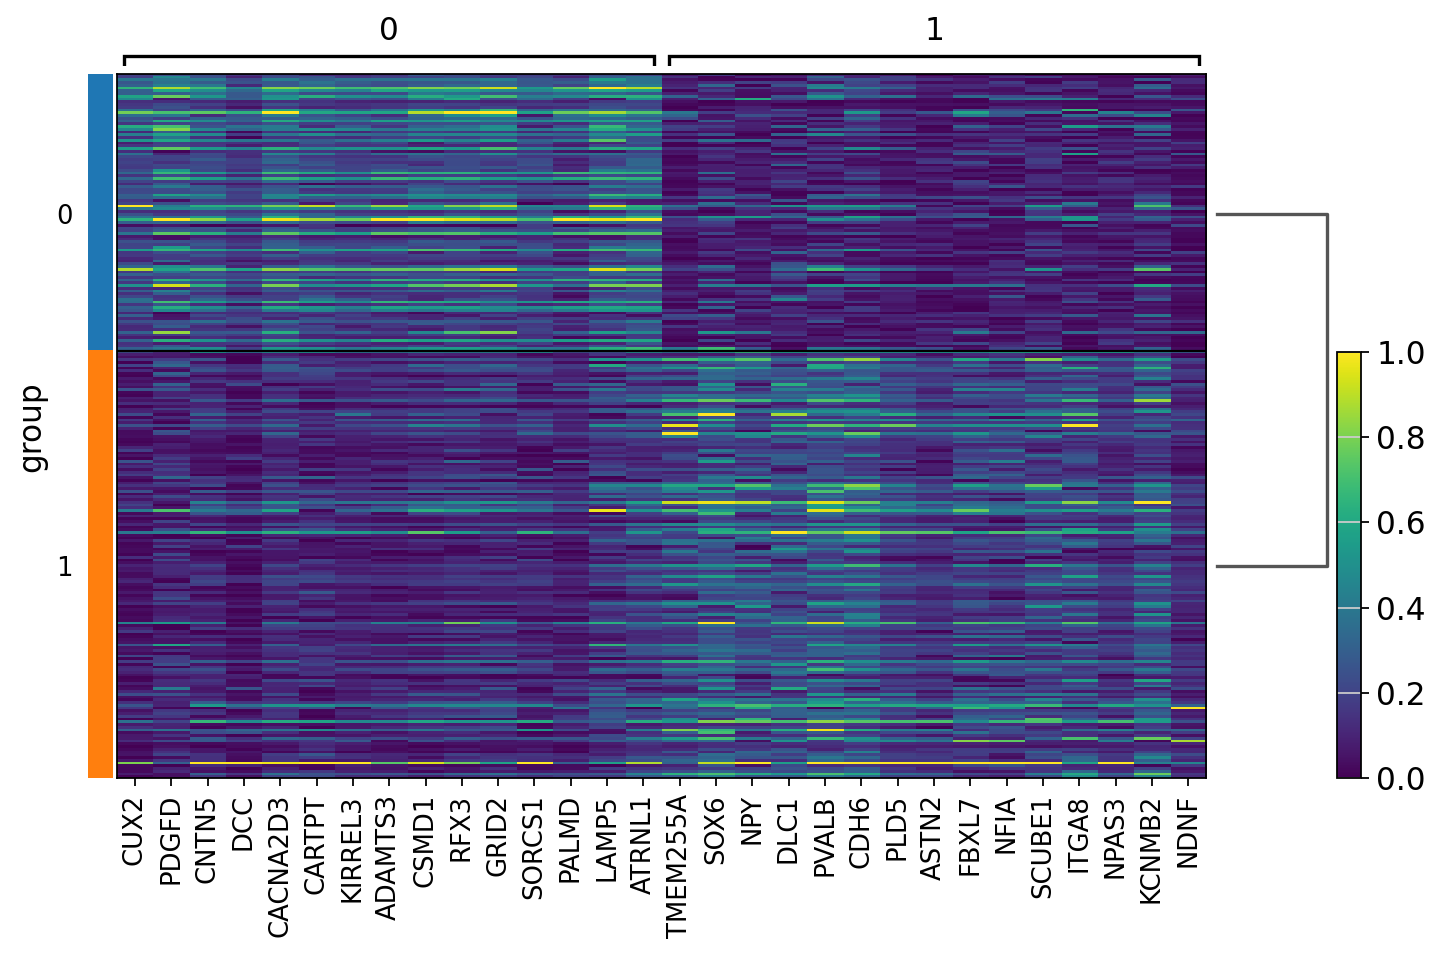

AnnData object with n_obs × n_vars = 257 × 140
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group', 'counts'
    uns: 'rank_genes_groups', 'group_colors', 'dendrogram_group'
    obsm: 'X_pca'
         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


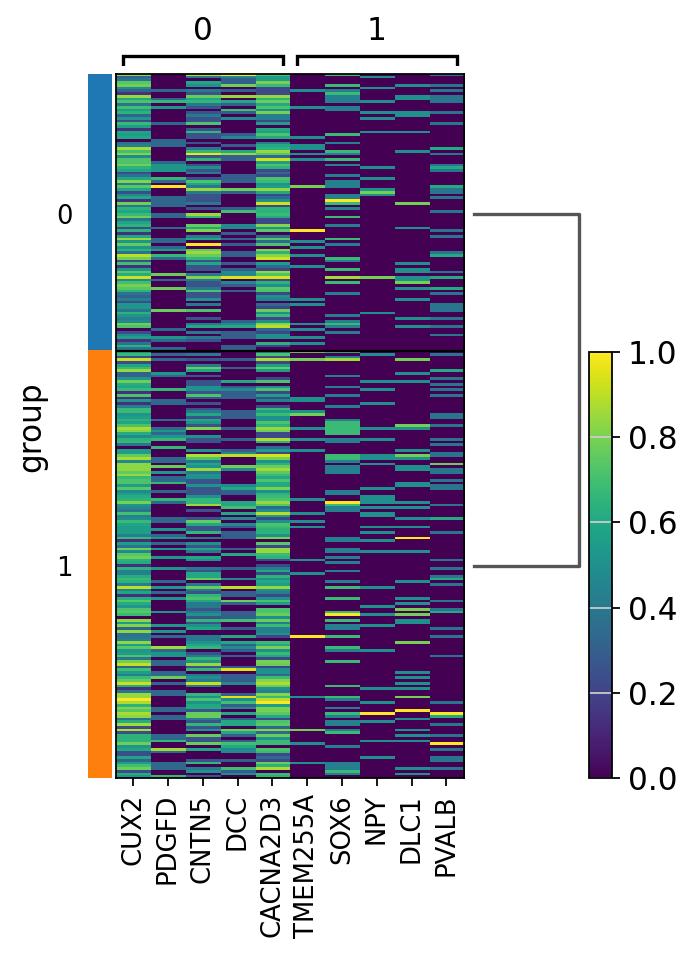

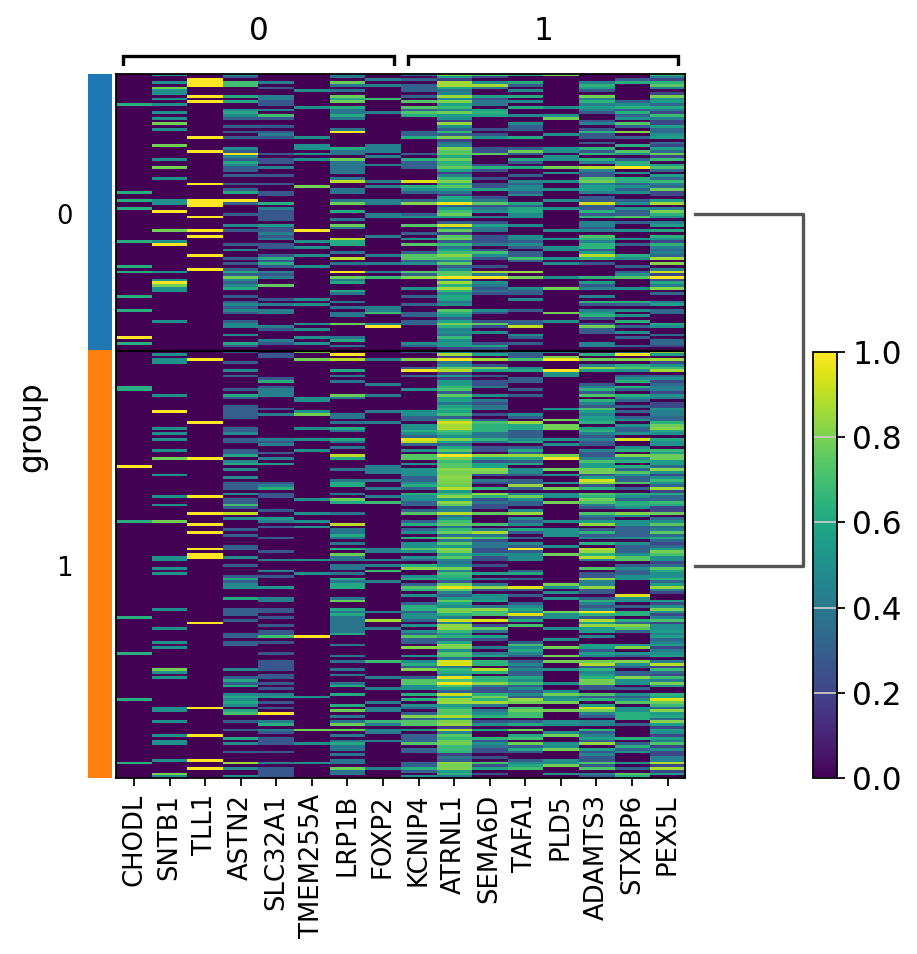

         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


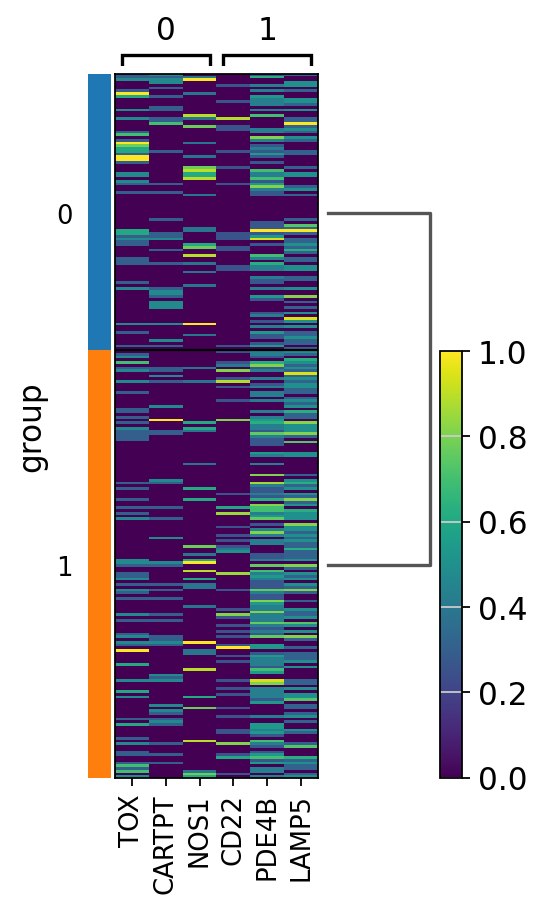

         Falling back to preprocessing with `sc.pp.pca` and default params.


/tmp/ipykernel_2159233/1816212048.py:32: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_type_strength.uns['rank_genes_groups']=adata_type_y.uns['rank_genes_groups']
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


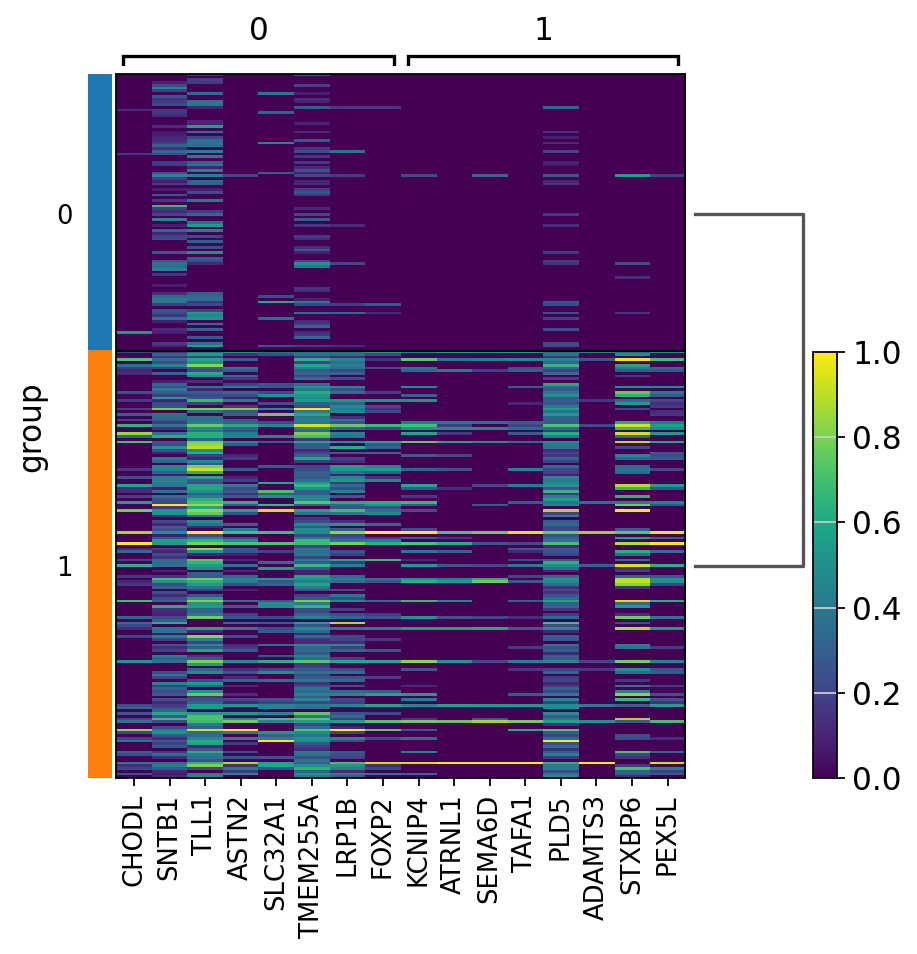

(257, 140) (387, 140) (257, 140) (257, 140)


In [18]:
select=5

adata_type_attention=ad.AnnData(X=np.abs(adata_type1.obsm["attention_score"]), obs=adata_type1.obs)
adata_type_attention=adata_type_attention[adata_type_attention.obs["group"].isin(["0","1"])]#,"2","2","3"
adata_type_attention.var_names=genes
sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')
#adata_type_attention=filter_extreme_percentiles(adata_type_attention,select)
sc.pl.rank_genes_groups_heatmap(adata_type_attention, n_genes=select+10, show_gene_labels=True,standard_scale='var', cmap='viridis')
print(adata_type_attention)

adata_type_y=ad.AnnData(X=adata_type1.obsm["y"], obs=adata_type1.obs)
adata_type_y=adata_type_y[adata_type_y.obs["group"].isin(["1","0"])]#,"2","3"
adata_type_y.var_names=genes
sc.tl.rank_genes_groups(adata_type_y, 'group', method='t-test')
adata_type_y.uns['rank_genes_groups']=adata_type_attention.uns['rank_genes_groups']
#adata_type_y=filter_extreme_percentiles(adata_type_y,select)
sc.pl.rank_genes_groups_heatmap(adata_type_y, n_genes=select, show_gene_labels=True,standard_scale='var', cmap='viridis')

sc.tl.rank_genes_groups(adata_type_y, 'group', method='t-test')
#adata_type_y=filter_extreme_percentiles(adata_type_y,select)
sc.pl.rank_genes_groups_heatmap(adata_type_y, n_genes=8, show_gene_labels=True,standard_scale='var', cmap='viridis')

adata_type_from_y=ad.AnnData(X=adata_type1.obsm["from_y"], obs=adata_type1.obs)
adata_type_from_y=adata_type_from_y[adata_type_from_y.obs["group"].isin(["1","0"])]#,"2","3"
adata_type_from_y.var_names=genes
sc.tl.rank_genes_groups(adata_type_from_y, 'group', method='t-test')
sc.pl.rank_genes_groups_heatmap(adata_type_from_y, n_genes=3, show_gene_labels=True,standard_scale='var', cmap='viridis')

adata_type_strength=ad.AnnData(X=adata_type1.obsm["strength"], obs=adata_type1.obs)
adata_type_strength.var_names=genes
adata_type_strength=adata_type_strength[adata_type_strength.obs["group"].isin(["1","0"])]
adata_type_strength.uns['rank_genes_groups']=adata_type_y.uns['rank_genes_groups']
sc.pl.rank_genes_groups_heatmap(adata_type_strength, n_genes=8, show_gene_labels=True,standard_scale='var', cmap='viridis')

print(adata_type_from_y.shape,adata_type1.shape,adata_type_y.shape,adata_type_attention.shape)

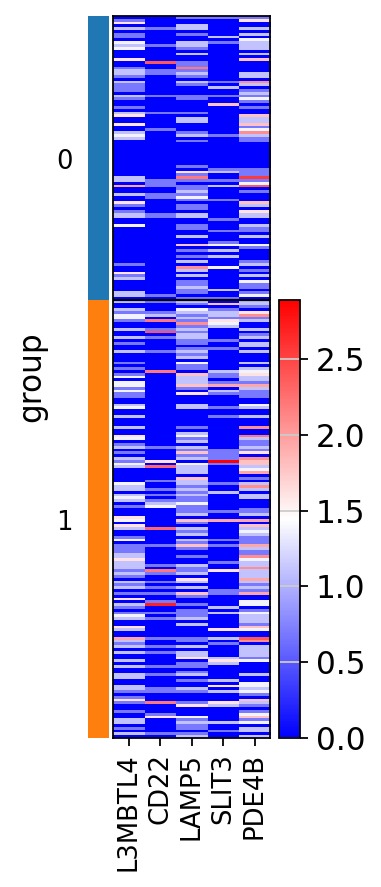

In [19]:
def plot_DEG(adata):
    results = adata.uns['rank_genes_groups']
    groups = results['names'].dtype.names  # Names of the groups

    # Initialize a set to collect unique significant genes
    significant_genes = set()
    
    # Iterate over all groups and select genes with p_adj < pval_threshold
    for group in groups:
        pvals_adj = results['pvals'][group]  # Adjusted p-values for the current group
        cutoff1=min(np.sort(pvals_adj)[60],0.05)
        genes = results['names'][group]  # Gene names for the current group
        
        # Filter genes based on adjusted p-value threshold
        sig_genes = genes[pvals_adj < cutoff1]
        significant_genes.update(sig_genes)

    # Convert set to list for further use
    significant_genes = list(significant_genes)
    
    # Plot the heatmap with the significant genes
    sc.pl.heatmap(adata, var_names=significant_genes, groupby="group",show_gene_labels=True,cmap='bwr')
plot_DEG(adata_type_from_y)

In [20]:
def extract_genes_and_pvals_by_group(adata, group_index, cutoff=0.05, up=True, name=None):
    # Extracting gene names and p-values from the adata object
    gene_names = adata.uns['rank_genes_groups']['names']
    p_values = adata.uns['rank_genes_groups']['pvals']
    logfoldchanges=adata.uns['rank_genes_groups']['logfoldchanges']
    p_adj=adata.uns['rank_genes_groups']['pvals_adj']
    
    # Lists to hold filtered gene names and their corresponding p-values
    filtered_genes = []
    filtered_pvals = []
    
    # Iterate through each group in the gene names and p-values
    for gene_group, pval_group,fold_group in zip(gene_names, p_values,logfoldchanges):
        gene = gene_group[group_index]
        pval = pval_group[group_index]
        foldchange=fold_group[group_index]
        
        # Check if p-value is below the cutoff and add to the lists if it is
        #print(pval,foldchange)
        if pval < cutoff and ((foldchange>0)==up):
            filtered_genes.append(gene)
            filtered_pvals.append(pval)
    
    return filtered_genes, filtered_pvals

sig_genes1,p_val1=extract_genes_and_pvals_by_group(adata_type_y,1,0.05,False)
print(sig_genes1)

sig_genes2,p_val2=extract_genes_and_pvals_by_group(adata_type_attention,1)
print(sig_genes2)

sig_genes3,p_val3=extract_genes_and_pvals_by_group(adata_type_from_y,1)
print(sig_genes3,p_val3)

print(np.sum([x in sig_genes2 for x in sig_genes1])/len(sig_genes1))
print([x in sig_genes2 for x in sig_genes1])

[]
['TMEM255A', 'SOX6', 'NPY', 'DLC1', 'PVALB', 'CDH6', 'PLD5', 'ASTN2', 'FBXL7', 'NFIA', 'SCUBE1', 'ITGA8', 'NPAS3', 'KCNMB2', 'NDNF', 'ID3', 'GRIN3A', 'FEZF2', 'COL11A1', 'ADAMTSL1', 'DACH1', 'SMYD1', 'SULF1', 'TACR1', 'CLSTN2', 'FGF12', 'HS3ST2', 'EYA4', 'TLL1', 'CD74', 'LRP1B', 'SLIT3', 'PDE4B', 'PAX6', 'NLGN1', 'ZNF804A', 'RYR3', 'DCN', 'GRIK3', 'PRRX1', 'HPSE2', 'LUZP2', 'MOG', 'ITGB8', 'L3MBTL4', 'THEMIS', 'BTBD11', 'GAD2', 'EGFR', 'KAZN', 'UNC5B', 'CTSS']
['CD22', 'PDE4B', 'LAMP5', 'SLIT3', 'L3MBTL4'] [0.005929644312036681, 0.008877977759410233, 0.020280359195158495, 0.027970882360093027, 0.029618404723747147]
nan
[]


/tmp/ipykernel_2159233/384401921.py:35: RuntimeWarning: invalid value encountered in scalar divide
  print(np.sum([x in sig_genes2 for x in sig_genes1])/len(sig_genes1))


In [21]:
def compute_log_fold_change(adata, name):
    # Check if 'group' is in adata.obs
    if 'group' not in adata.obs.columns:
        raise ValueError("The adata object must contain 'group' in adata.obs")

    # Get unique groups
    groups = list(sorted(adata.obs['group'].unique()))
    print(groups)
    if len(groups) != 2:
        raise ValueError("There must be exactly two groups in 'adata.obs['group']'")

    # Calculate mean expression for each group
    means = {}
    for group in groups:
        subset = adata[adata.obs['group'] == group]
        means[group] = np.mean(subset.X, axis=0)
    
    # Calculate log-fold change
    log_fold_change = np.log(means[groups[1]] / means[groups[0]])

    # Convert log_fold_change to a pandas DataFrame
    gene_names = adata.var_names
    log_fold_change_df = pd.DataFrame(log_fold_change, index=gene_names, columns=['log_fold_change'])

    # Save to CSV
    name1=name.replace("/","-")
    log_fold_change_df.to_csv(f"./DEG/{name1}.csv")

    print(f"Log-fold change written to {name}.csv")

compute_log_fold_change(adata_type_y, desired_CCC_type)

['0', '1']
Log-fold change written to Microglia-PVM->L2/3 IT.csv


In [22]:
compute_log_fold_change(adata_type_from_y, desired_CCC_type+"_from")

['0', '1']
Log-fold change written to Microglia-PVM->L2/3 IT_from.csv
